### Analyze Bias/Variance Tradeoff

- Generate a dataset consisting of a independent variable $x$ and a dependent variable $y$ (targets), related by ground truth model $y=f(x)$ with $f(x)=x^2+sin(x)$. Generate $N=10000$ training observations $x_i,y_i$ uniformly distributed along the interval $x\in[-x_{max},x_{max}]$ with $x_{max}=2$ using the following generative model
$$
y_i=f(x_i)+\epsilon_i
$$
The measurement noise is sampled from a gaussian distribution $\epsilon_i\sim {\cal N}(0,\sigma_\epsilon^2)$ with mean zero and standard deviation $\sigma_\epsilon=0.5$.
- Generate a test set consisting of a $N_{test}=100$ observations $x^{test}_i,y^{test}_i$, for $i=1,\ldots,N_{test}$ uniformly distributed in the interval $[x_{max},x_{max}+1]$.
- Visualize ground truth model, training observations, and test set.

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas

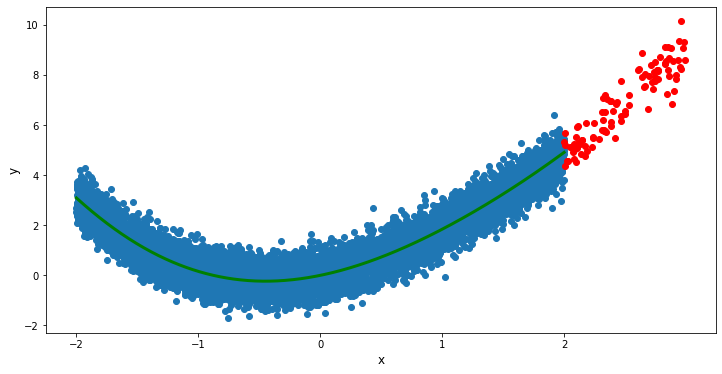

In [ ]:
## Ground Truth Model

def f(x):
    y_return = x**2 + np.sin(x)
    return y_return

# full dataset (x,y) set consists of N observations in the interval [-x_max,x_max]
# we will subsample from this to create different training sets

N=10000
x_max=2
x=x_max*(2*np.random.rand(N)-1) # uniform distribution
# measurement noise
sigma_epsilon=0.5
mean_epsilon=0
# generate noise from a gaussian distribution of mean mean_epsilon and standard deviation sigma_epsilon
epsilon=mean_epsilon+sigma_epsilon*np.random.randn(N)


# full dataset set (x,y)
# target labels
y=f(x)+epsilon

# test set outside of training range:
n_test=100

x_test=x_max+np.random.rand(n_test)
epsilon1=sigma_epsilon*np.random.randn(n_test)
y_test=f(x_test)+epsilon1

#plot
plt.figure(figsize=(12, 6))
x_range = np.linspace(-x_max, x_max, 1000)
# ground truth model
plt.plot(x_range, f(x_range), 'g', linewidth=3.0)
# training set
plt.scatter(x, y)
# test set
plt.scatter(x_test, y_test, c='r')
#
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
plt.xticks(np.arange(-x_max, x_max + 1))
plt.show()

- The goal is to learn a function $\hat f(x)$ that best predicts the targets in the test set - namely, leads to the smallest generalization error. Compare several alternative models, within the class of polynomials of degree $d$: $
\hat f_d(x|w)=\sum_{i=0}^d w^{(d)}_i x^i$, where $w^{(d)}_i$ are the parameters to be learned using polynomial regression. Pick a range $d=0,\ldots,5$.
- I will perform $a=1,\ldots,n_{exp}=1000$ experiments. For each experiment, I will create a new training set $S_{train}^a=[x_i,y_i]$ by randomly subsampling $N_{train}=0.01N$ of the original $N$ training observations, then fit each model $\hat f_d(x|w)$ to the training set $S_{train}^a$, to learn the parameters $w^{(d)}_i(a)\equiv w^{(d)}_i(S_{train}^a)$.
- For each experiment $a$ with learned parameters $w^{(d)}_i(a)$, I will then make a prediction for all points in the test set $y^{test}_i=\hat f(x^{test}_i|w^{(d)}_i(a)$). Crucially, the learned parameters $w^{(d)}_i(a)$ and thus the prediction $y^{test}_i$ will be different in the different experiments: they are functions of the training set  $S_{train}^a$.

In [ ]:
d_arr=[0,1,2,3,4,5]

#our class of models to fit: polynomials of degree d
def f_hat(x, w):
    d = len(w) - 1
    return np.sum(w * np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T, 1)

# fits
n_exp=1000
n=int(0.01*N)

# train
train_squared_error=np.zeros((len(d_arr),n_exp))
y_hat_test=np.zeros((len(d_arr),n_exp,n_test))
for r in range(n_exp):
    idx=np.random.permutation(N)[:n]
    x_train,y_train=x[idx],y[idx]
    for k in range(len(d_arr)):
        d=d_arr[k]
        w=np.polyfit(x_train,y_train,d)
        train_squared_error[k,r] = np.mean((y_train - f_hat(x_train,w))**2)
        y_hat_test[k,r,:]=f_hat(x_test,w)

- For each experiment $a$ and each polynomial model $d$, estimate the average squared training error
$$err_{train}(d,a)={1\over N_{train}}\sum_{i\in N_{train}}[\hat f_d(x_i|w^{(d)}(a))-y_i]^2 \ ,$$
the average squared test error
$$err_{test}(d,a)={1\over N_{test}}\sum_{i\in N_{test}}[\hat f_d(x^{test}_i|w^{(d)}(a))-y^{test}_i]^2 \ ,$$
and the squared irreducible error $err_{\epsilon}=\sigma_\epsilon^2$, and also the average bias squared and the variance of the predictions in the test set. For each $d$, calculate the mean and standard deviation of all these quantities across experiments.

In [ ]:
test_squared_error=np.mean((y_hat_test-y_test)**2,1)
bias_squared=(np.mean(y_hat_test,1)-f(x_test))**2
var_y_hat_test=np.var(y_hat_test,1)

# test squared error
t_squared_sd = (np.var(test_squared_error,1))**(0.5)
t_squared_mean = np.mean((test_squared_error),1)

# test squared error
tr_squared_sd = (np.var(train_squared_error,1))**(0.5)
tr_squared_mean = np.mean(train_squared_error,1)

# bias
bias_sd = (np.var(bias_squared,1))**(0.5)
bias_mean = np.mean(bias_squared,1)

# variance
variance_sd = (np.var(var_y_hat_test,1))**(0.5)
variance_mean = np.mean((var_y_hat_test),1)


In [ ]:
## Test Squared Error
t_squared_data = {'mean': t_squared_mean,
           'sd': t_squared_sd}
t_df = pandas.DataFrame(data=t_squared_data)
print("\nTest Squared Error:")
print(t_df)

## Train Squared Error
t_squared_data = {'mean': tr_squared_mean,
           'sd': tr_squared_sd}
t_df = pandas.DataFrame(data=t_squared_data)
print("\nTrain Squared Error:")
print(t_df)

## bias
t_squared_data = {'mean': bias_mean,
           'sd': bias_sd}
t_df = pandas.DataFrame(data=t_squared_data)
print("\nBias:")
print(t_df)

## variance
t_squared_data = {'mean': variance_mean,
           'sd': variance_sd}
t_df = pandas.DataFrame(data=t_squared_data)
print("\nVariance:")
print(t_df)

## Irreducible Error

irred_sd = np.var((sigma_epsilon**2)*np.ones_like(d_arr))
irred_mean = np.mean((sigma_epsilon**2)*np.ones_like(d_arr))

print("Irreducible mean:", irred_mean, "Irreducible sd", irred_sd)


Test Squared Error:
        mean         sd
0  32.618000  15.983176
1  16.913000   9.953134
2   1.677966   1.948946
3   0.814626   0.829888
4   2.147024   2.027050
5   9.527853  11.055392

Train Squared Error:
       mean        sd
0  2.227590  0.278013
1  1.634511  0.214048
2  0.263652  0.038303
3  0.235185  0.034123
4  0.232747  0.033717
5  0.230210  0.033441

Bias:
        mean         sd
0  32.410437  14.728117
1  16.570678   8.852383
2   1.251724   0.928708
3   0.220190   0.250176
4   0.262328   0.296154
5   0.009886   0.006357

Variance:
       mean            sd
0  0.022220  6.938894e-18
1  0.118206  2.712707e-02
2  0.074272  3.779253e-02
3  0.289066  2.274858e-01
4  1.580920  1.609540e+00
5  9.194025  1.096533e+01
Irreducible mean: 0.25 Irreducible sd 0.0


- Plot their mean and standard deviation as a function of $d$, and check that the test error satisfies the bias/variance relation.

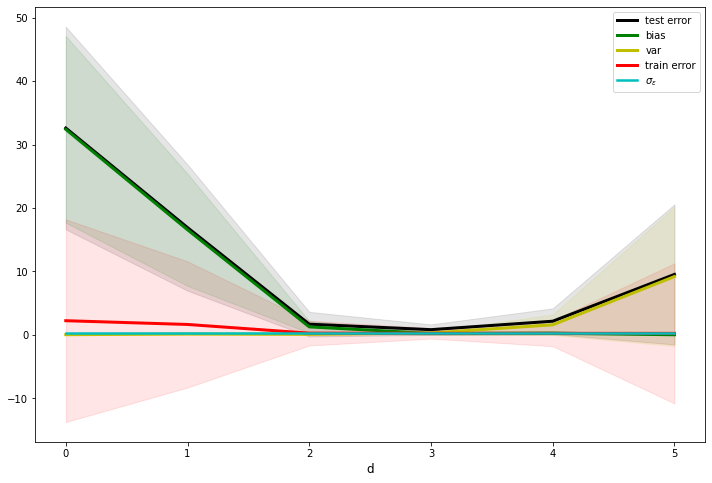

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(d_arr,t_squared_mean,'k',linewidth=3.0)
plt.plot(d_arr,bias_mean,'g',linewidth=3.0)
plt.plot(d_arr,variance_mean,'y',linewidth=3.0)
plt.plot(d_arr,tr_squared_mean,'r',linewidth=3.0)
plt.plot(d_arr,(sigma_epsilon**2)*np.ones_like(d_arr),'c',linewidth=2.5)

## Standard Deviation
plt.fill_between(d_arr, t_squared_mean - t_squared_sd,
                t_squared_mean + t_squared_sd, color='k', alpha=0.1)
plt.fill_between(d_arr, tr_squared_mean - t_squared_sd,
                tr_squared_mean + t_squared_sd, color='r', alpha=0.1)
plt.fill_between(d_arr, bias_mean - bias_sd,
                bias_mean + bias_sd, color='g', alpha=0.1)
plt.fill_between(d_arr, variance_mean - variance_sd,
                variance_mean + variance_sd, color='y', alpha=0.1)

plt.xticks(d_arr)
plt.xlabel('d',size=12)
plt.legend(['test error','bias','var',"train error", "$\sigma_\epsilon$"])
plt.show()

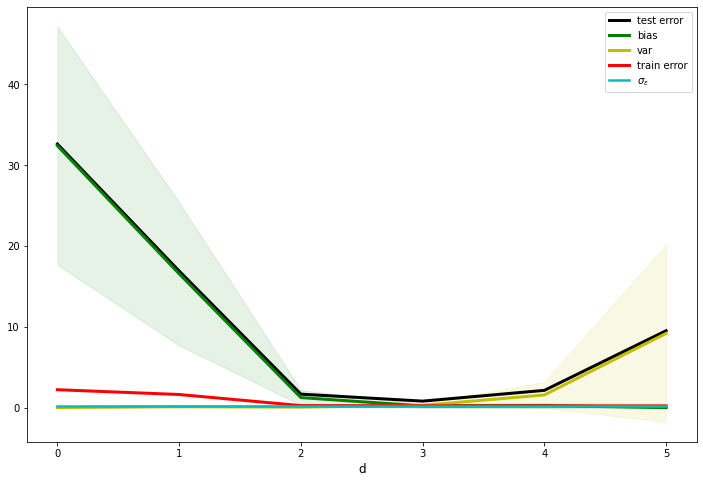

In [ ]:
## Just looking at standard deviation of bias and variance
plt.figure(figsize=(12,8))
plt.plot(d_arr,t_squared_mean,'k',linewidth=3.0)
plt.plot(d_arr,bias_mean,'g',linewidth=3.0)
plt.plot(d_arr,variance_mean,'y',linewidth=3.0)
plt.plot(d_arr,tr_squared_mean,'r',linewidth=3.0)
plt.plot(d_arr,(sigma_epsilon**2)*np.ones_like(d_arr),'c',linewidth=2.5)

## Standard Deviation
plt.fill_between(d_arr, bias_mean - bias_sd,
                bias_mean + bias_sd, color='g', alpha=0.1)
plt.fill_between(d_arr, variance_mean - variance_sd,
                variance_mean + variance_sd, color='y', alpha=0.1)


plt.xticks(d_arr)
plt.xlabel('d',size=12)
plt.legend(['test error','bias','var',"train error", "$\sigma_\epsilon$"])
plt.show()

- Which value of $d$ gives the lowest test error? That will be the polynomial model that best approximates the ground truth model $f(x)$.

#### Lowest Test Error: $d=3$

The value $d=3$ produces the lowest test error with an average of 0.88. This was roughly 1 lower than $d=2$ and about 1.5 lower than $d=4$.